9999999
Create data function finished. Returning X of size: [ (400, 2) ] and class_labels of size: [ (400,) ].
9999999
Create data function finished. Returning X of size: [ (4000, 2) ] and class_labels of size: [ (4000,) ].

--- Grid Search Hyperparameter Tuning ---

--- Plotting Grid Search Results ---


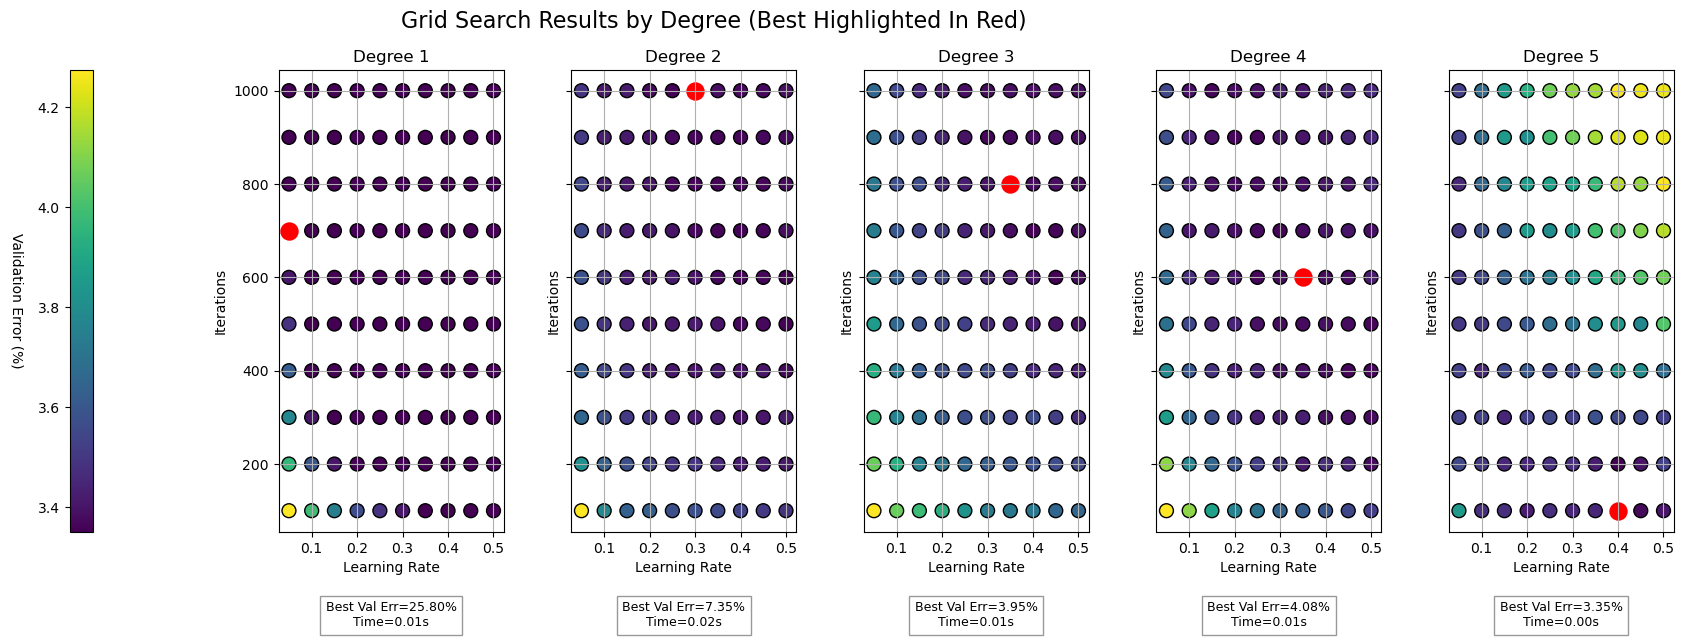


--- Polynomial Degree Comparison ---
Testing Polynomial Degree 1...
Degree: 1, Train Error: 8.50%, Validation Error: 9.78%
Testing Polynomial Degree 2...
Degree: 2, Train Error: 3.00%, Validation Error: 5.45%
Testing Polynomial Degree 3...
Degree: 3, Train Error: 2.75%, Validation Error: 4.55%
Testing Polynomial Degree 4...
Degree: 4, Train Error: 2.75%, Validation Error: 4.40%
Testing Polynomial Degree 5...
Degree: 5, Train Error: 2.00%, Validation Error: 3.88%

Best Polynomial Degree: 5


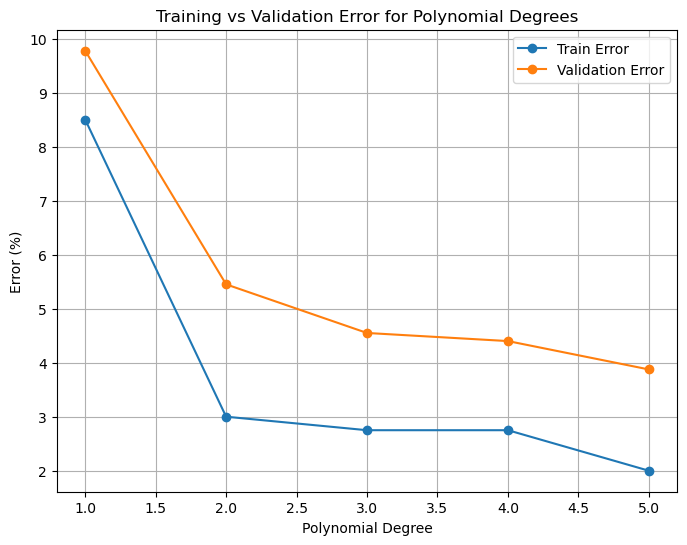


Best Polynomial Degree: 5

--- Final Model Performance ---
Training Loss: 0.0506, Validation Loss: 0.1722
Training Error: 1.75%, Validation Error: 4.20%

--- 3D Sigmoid Surface Visualization ---


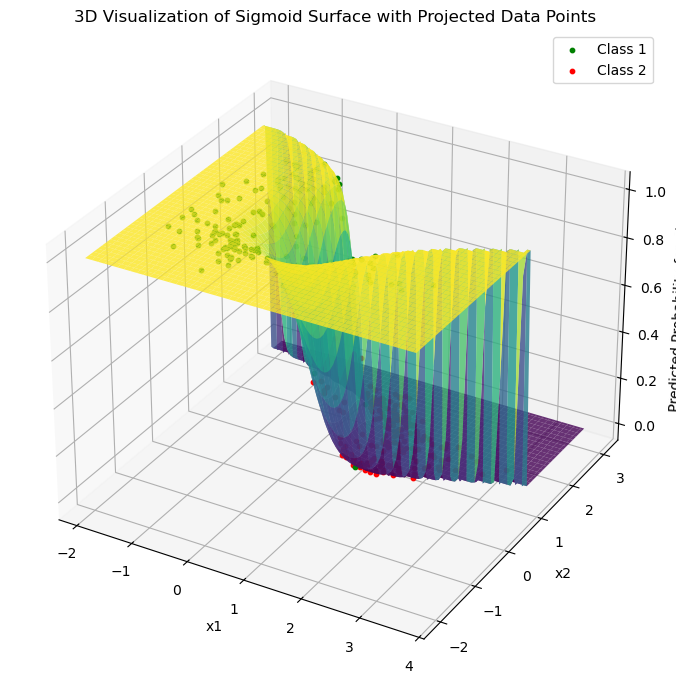

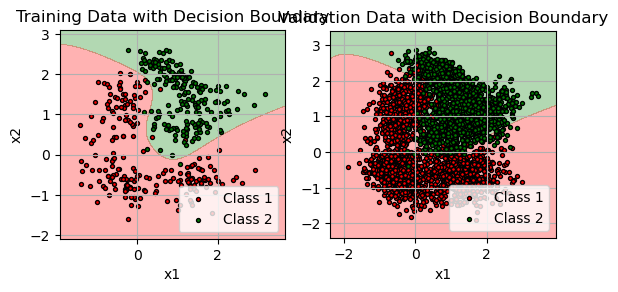

In [36]:
###############################################
# Author & Copyright: Konstantinos Kamnitsas
# Modified by: AbdoAllah Mohammad
# B1 - Project - 2024
###############################################
import sys
import os
import time

# Add the project root directory to the Python path
project_root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(project_root)

import numpy as np
import matplotlib.pyplot as plt

from data.create_data import create_data
from models.logistic_regression import create_features_for_poly, log_regr
from models.optimizer import grad_descent
from scripts.utils import classif_error, mean_logloss
from scripts.visualization import plot_3d_sigmoid_surface, plot_decision_boundary
from experiments.hyperparameter_tuning import hyperparameter_tuning
from experiments.polynomial_analysis import polynomial_degree_comparison, training_size_analysis
from experiments.grid_search_hyperparameters import grid_search_hyperparameters

def plot_grid_search_with_best(results):
    degrees = sorted(set(res[0] for res in results))  # Unique degrees
    fig, axes = plt.subplots(1, len(degrees), figsize=(24, 6), sharey=True, gridspec_kw={'wspace': 0.3})

    scatter = None  # Define scatter outside loop for colorbar reference
    for idx, degree in enumerate(degrees):
        ax = axes[idx]
        subset = [res for res in results if res[0] == degree]

        x_vals = [res[1] for res in subset]  # Learning rates
        y_vals = [res[2] for res in subset]  # Iterations
        z_val = [res[4] for res in subset]  # Validation errors
        times = [res[5] for res in subset]  # Times

        # Find the best (minimum validation error)
        min_val_error = min(z_val)
        best_idx = z_val.index(min_val_error)
        best_lr = x_vals[best_idx]
        best_iter = y_vals[best_idx]
        best_time = times[best_idx]

        scatter = ax.scatter(x_vals, y_vals, c=z_val, cmap='viridis', s=100, edgecolor='black')
        ax.set_title(f"Degree {degree}")
        ax.set_xlabel("Learning Rate")
        ax.set_ylabel("Iterations")
        ax.grid(True)

        # Highlight the best combination
        ax.scatter([best_lr], [best_iter], color='red', s=150, label=f"Best Val Err={min_val_error:.2f}%")
        ax.text(0.5, -0.15, f"Best Val Err={min_val_error:.2f}%\nTime={best_time:.2f}s", ha='center', va='top', transform=ax.transAxes, fontsize=9, bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
        

    # Add colorbar to the far left of the figure
    cbar = fig.colorbar(scatter, ax=axes, label="Validation Error (%)", location='left', shrink=1)
    cbar.ax.set_ylabel("Validation Error (%)", rotation=270, labelpad=20)
    plt.suptitle("Grid Search Results by Degree (Best Highlighted In Red)", fontsize=16)
    # rect=[left, bottom, right, top]
    # plt.tight_layout(rect=[-0.8, 0, 0.98, 0.92])
    plt.show()

if __name__ == "__main__":
    """
    Main execution script for:
        1. Hyperparameter Tuning
        2. Polynomial Degree Comparison
        3. Decision Boundary Visualization
    """

    # --- Hyperparameters ---
    max_degree = 5        # Maximum polynomial degree to test
    learning_rate = 0.1   # Default learning rate
    gd_iters = 1000       # Default gradient descent iterations
    degrees = [1, 2, 3, 4, 5]
    learning_rates = np.arange(0.05, 0.55, 0.05)
    iterations = range(100, 1100, 100)

    # --- Create Training Data ---
    n_samples_train = 400
    X_train, class_labels_train = create_data(n_samples_train)
    y_train = (class_labels_train == 1).astype(int)  # Convert labels to {0, 1}

    # --- Create Validation Data ---
    n_samples_val = 4000
    X_val, class_labels_val = create_data(n_samples_val)
    y_val = (class_labels_val == 1).astype(int)  # Convert labels to {0, 1}

    # --- 1. Grid Search Hyperparameter Tuning ---
    print("\n--- Grid Search Hyperparameter Tuning ---")
    results = []
    for degree in degrees:
        for lr in learning_rates:
            for iters in iterations:
                start_time = time.time()
                theta = grad_descent(create_features_for_poly(X_train, degree), y_train, learning_rate=lr, iters_total=iters)
                end_time = time.time()

                train_error = classif_error(y_train, log_regr(create_features_for_poly(X_train, degree), theta))
                val_error = classif_error(y_val, log_regr(create_features_for_poly(X_val, degree), theta))
                elapsed_time = end_time - start_time

                results.append((degree, lr, iters, train_error, val_error, elapsed_time))

    # --- Plot Grid Search Results ---
    print("\n--- Plotting Grid Search Results ---")
    plot_grid_search_with_best(results)

    # --- Continue with Polynomial Degree Comparison ---
    print("\n--- Polynomial Degree Comparison ---")
    best_degree = polynomial_degree_comparison(X_train, y_train, X_val, y_val, max_degree)

    # --- 3. Train Model with Best Degree ---
    print(f"\nBest Polynomial Degree: {best_degree}")
    X_train_best = create_features_for_poly(X_train, best_degree)
    X_train_best = np.concatenate((X_train_best, np.ones((X_train_best.shape[0], 1))), axis=1)  # Add bias

    X_val_best = create_features_for_poly(X_val, best_degree)
    X_val_best = np.concatenate((X_val_best, np.ones((X_val_best.shape[0], 1))), axis=1)  # Add bias

    theta_opt = grad_descent(X_train_best, y_train, learning_rate=0.5, iters_total=1000)

    # --- 4. Evaluate Final Model ---
    train_loss = mean_logloss(X_train_best, y_train, theta_opt)
    val_loss = mean_logloss(X_val_best, y_val, theta_opt)
    train_error = classif_error(y_train, log_regr(X_train_best, theta_opt))
    val_error = classif_error(y_val, log_regr(X_val_best, theta_opt))

    print("\n--- Final Model Performance ---")
    print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    print(f"Training Error: {train_error:.2f}%, Validation Error: {val_error:.2f}%")

    # --- 5. Plot Decision Boundaries ---
    plt.figure(figsize=(10, 5))

    # Extension
    # --- 6. 3D Sigmoid Surface Visualization ---
    print("\n--- 3D Sigmoid Surface Visualization ---")
    plt.close('all')  # Close all previous plots to avoid empty plot issues
    plot_3d_sigmoid_surface(X_train, class_labels_train, theta_opt, degree=best_degree)

    # Training Data
    plt.subplot(1, 2, 1, aspect='equal')
    plot_decision_boundary(X_train, theta_opt, class_labels_train, best_degree, marker_size=8)
    plt.title("Training Data with Decision Boundary")

    # Validation Data
    plt.subplot(1, 2, 2, aspect='equal') 
    plot_decision_boundary(X_val, theta_opt, class_labels_val, best_degree, marker_size=8)
    plt.title("Validation Data with Decision Boundary")

    plt.show()


9999999
Create data function finished. Returning X of size: [ (400, 2) ] and class_labels of size: [ (400,) ].
9999999
Create data function finished. Returning X of size: [ (4000, 2) ] and class_labels of size: [ (4000,) ].

--- Grid Search Hyperparameter Tuning ---

--- Plotting Grid Search Results ---


/tmp/ipykernel_89784/1391534585.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


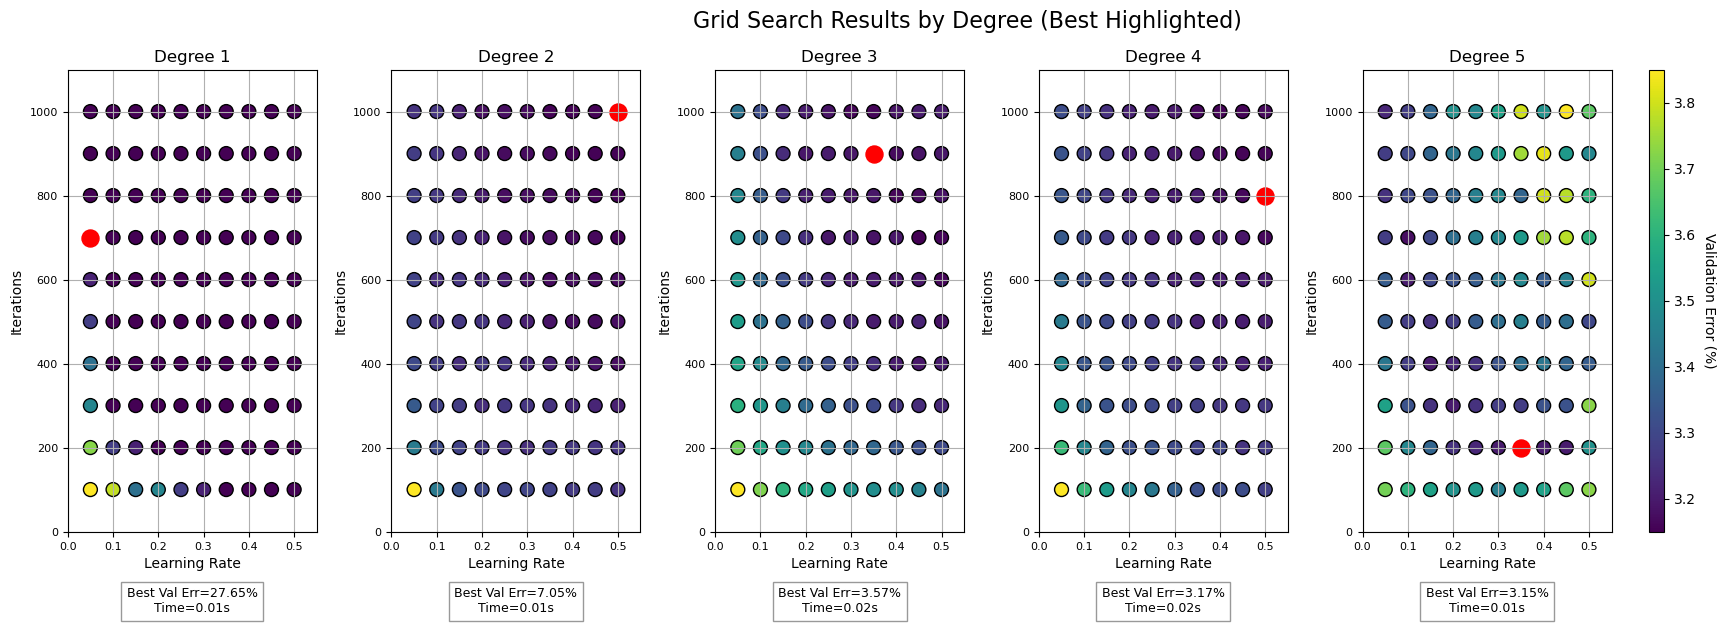


--- Polynomial Degree Comparison ---
Testing Polynomial Degree 1...
Degree: 1, Train Error: 12.50%, Validation Error: 10.38%
Testing Polynomial Degree 2...
Degree: 2, Train Error: 7.00%, Validation Error: 5.78%
Testing Polynomial Degree 3...
Degree: 3, Train Error: 5.25%, Validation Error: 4.78%
Testing Polynomial Degree 4...
Degree: 4, Train Error: 5.50%, Validation Error: 4.12%
Testing Polynomial Degree 5...
Degree: 5, Train Error: 5.25%, Validation Error: 3.50%

Best Polynomial Degree: 5


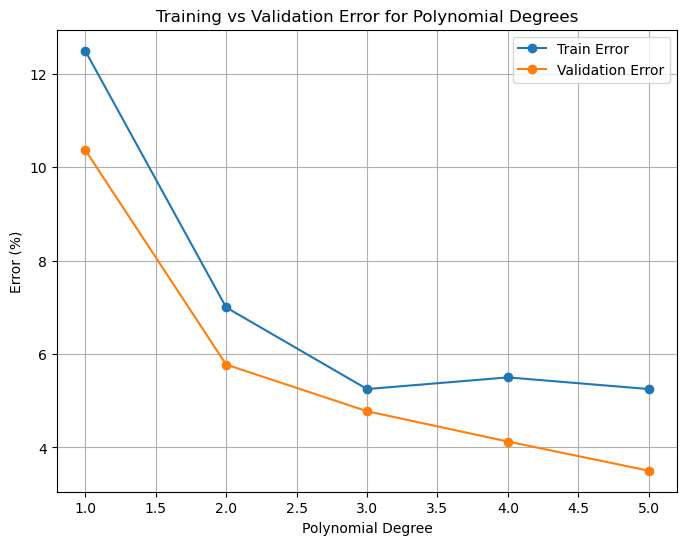


Best Polynomial Degree: 5

--- Final Model Performance ---
Training Loss: 0.1093, Validation Loss: 0.1125
Training Error: 5.25%, Validation Error: 3.55%

--- 3D Sigmoid Surface Visualization ---


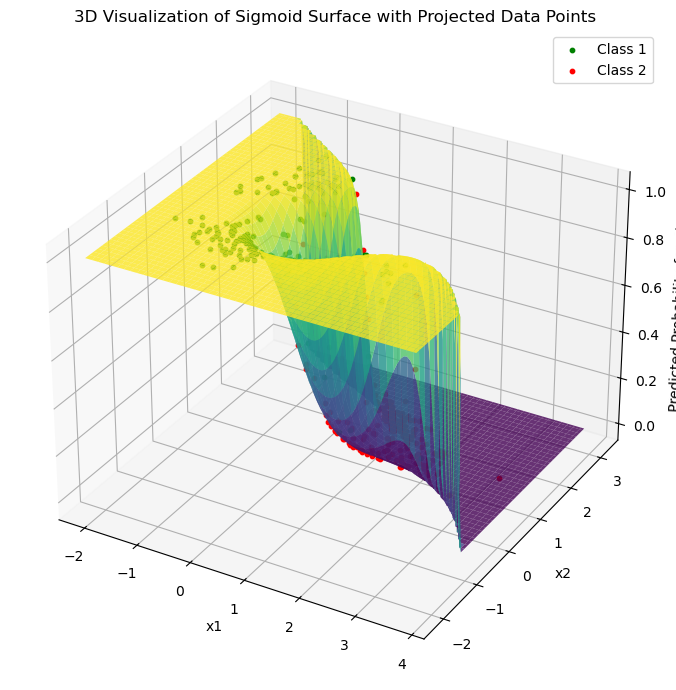

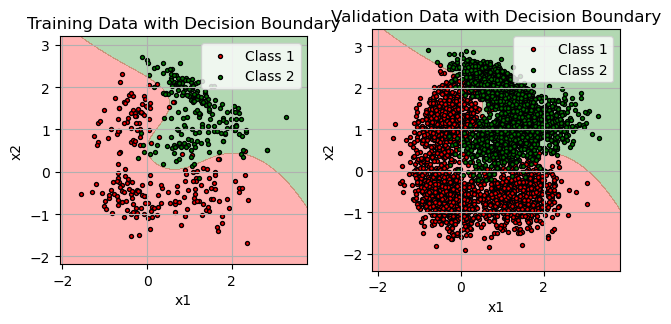

In [40]:
###############################################
# Author & Copyright: Konstantinos Kamnitsas
# Modified by: AbdoAllah Mohammad
# B1 - Project - 2024
###############################################
import sys
import os
import time

# Add the project root directory to the Python path
project_root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(project_root)

import numpy as np
import matplotlib.pyplot as plt

from data.create_data import create_data
from models.logistic_regression import create_features_for_poly, log_regr
from models.optimizer import grad_descent
from scripts.utils import classif_error, mean_logloss
from scripts.visualization import plot_3d_sigmoid_surface, plot_decision_boundary
from experiments.hyperparameter_tuning import hyperparameter_tuning
from experiments.polynomial_analysis import polynomial_degree_comparison, training_size_analysis
from experiments.grid_search_hyperparameters import grid_search_hyperparameters


def plot_grid_search_with_best(results):
    degrees = sorted(set(res[0] for res in results))  # Unique degrees
    fig, axes = plt.subplots(1, len(degrees), figsize=(24, 6), gridspec_kw={'wspace': 0.3})

    scatter = None  # Define scatter outside loop for colorbar reference
    for idx, degree in enumerate(degrees):
        ax = axes[idx]
        subset = [res for res in results if res[0] == degree]

        x_vals = [res[1] for res in subset]  # Learning rates
        y_vals = [res[2] for res in subset]  # Iterations
        z_val = [res[4] for res in subset]  # Validation errors
        times = [res[5] for res in subset]  # Times

        # Find the best (minimum validation error)
        min_val_error = min(z_val)
        best_idx = z_val.index(min_val_error)
        best_lr = x_vals[best_idx]
        best_iter = y_vals[best_idx]
        best_time = times[best_idx]

        scatter = ax.scatter(x_vals, y_vals, c=z_val, cmap='viridis', s=100, edgecolor='black')
        ax.set_title(f"Degree {degree}", fontsize=12)
        ax.set_xlabel("Learning Rate", fontsize=10)
        ax.set_ylabel("Iterations", fontsize=10)
        ax.set_xlim(0, 0.55)
        ax.set_ylim(0, 1100)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.grid(True)

        # Highlight the best combination
        ax.scatter([best_lr], [best_iter], color='red', s=150, label=f"Best Val Err={min_val_error:.2f}%")
        ax.text(0.5, -0.12, f"Best Val Err={min_val_error:.2f}%\nTime={best_time:.2f}s", ha='center', va='top', transform=ax.transAxes, fontsize=9, bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
        


    # Add colorbar to the figure
    cbar = fig.colorbar(scatter, ax=axes, label="Validation Error (%)", location='right', pad=0.02, aspect=30)
    cbar.ax.set_ylabel("Validation Error (%)", rotation=270, labelpad=15, fontsize=10)
    plt.suptitle("Grid Search Results by Degree (Best Highlighted)", fontsize=16)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    """
    Main execution script for:
        1. Hyperparameter Tuning
        2. Polynomial Degree Comparison
        3. Decision Boundary Visualization
    """

    # --- Hyperparameters ---
    max_degree = 5        # Maximum polynomial degree to test
    learning_rate = 0.1   # Default learning rate
    gd_iters = 1000       # Default gradient descent iterations
    degrees = [1, 2, 3, 4, 5]
    learning_rates = np.arange(0.05, 0.55, 0.05)
    iterations = range(100, 1100, 100)

    # --- Create Training Data ---
    n_samples_train = 400
    X_train, class_labels_train = create_data(n_samples_train)
    y_train = (class_labels_train == 1).astype(int)  # Convert labels to {0, 1}

    # --- Create Validation Data ---
    n_samples_val = 4000
    X_val, class_labels_val = create_data(n_samples_val)
    y_val = (class_labels_val == 1).astype(int)  # Convert labels to {0, 1}

    # --- 1. Grid Search Hyperparameter Tuning ---
    print("\n--- Grid Search Hyperparameter Tuning ---")
    results = []
    for degree in degrees:
        for lr in learning_rates:
            for iters in iterations:
                start_time = time.time()
                theta = grad_descent(create_features_for_poly(X_train, degree), y_train, learning_rate=lr, iters_total=iters)
                end_time = time.time()

                train_error = classif_error(y_train, log_regr(create_features_for_poly(X_train, degree), theta))
                val_error = classif_error(y_val, log_regr(create_features_for_poly(X_val, degree), theta))
                elapsed_time = end_time - start_time

                results.append((degree, lr, iters, train_error, val_error, elapsed_time))

    # --- Plot Grid Search Results ---
    print("\n--- Plotting Grid Search Results ---")
    plot_grid_search_with_best(results)

    # --- Continue with Polynomial Degree Comparison ---
    print("\n--- Polynomial Degree Comparison ---")
    best_degree = polynomial_degree_comparison(X_train, y_train, X_val, y_val, max_degree)

    # --- 3. Train Model with Best Degree ---
    print(f"\nBest Polynomial Degree: {best_degree}")
    X_train_best = create_features_for_poly(X_train, best_degree)
    X_train_best = np.concatenate((X_train_best, np.ones((X_train_best.shape[0], 1))), axis=1)  # Add bias

    X_val_best = create_features_for_poly(X_val, best_degree)
    X_val_best = np.concatenate((X_val_best, np.ones((X_val_best.shape[0], 1))), axis=1)  # Add bias

    theta_opt = grad_descent(X_train_best, y_train, learning_rate=0.5, iters_total=1000)

    # --- 4. Evaluate Final Model ---
    train_loss = mean_logloss(X_train_best, y_train, theta_opt)
    val_loss = mean_logloss(X_val_best, y_val, theta_opt)
    train_error = classif_error(y_train, log_regr(X_train_best, theta_opt))
    val_error = classif_error(y_val, log_regr(X_val_best, theta_opt))

    print("\n--- Final Model Performance ---")
    print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    print(f"Training Error: {train_error:.2f}%, Validation Error: {val_error:.2f}%")

    # --- 5. Plot Decision Boundaries ---
    plt.figure(figsize=(10, 10))  # Adjusted to make subplots square

    # Extension
    # --- 6. 3D Sigmoid Surface Visualization ---
    print("\n--- 3D Sigmoid Surface Visualization ---")
    plt.close('all')  # Close all previous plots to avoid empty plot issues
    plot_3d_sigmoid_surface(X_train, class_labels_train, theta_opt, degree=best_degree)

    # Training Data
    plt.subplot(1, 2, 1, aspect='equal')  # Make subplot square
    plot_decision_boundary(X_train, theta_opt, class_labels_train, best_degree, marker_size=8)
    plt.title("Training Data with Decision Boundary")

    # Validation Data
    plt.subplot(1, 2, 2, aspect='equal')  # Make subplot square
    plot_decision_boundary(X_val, theta_opt, class_labels_val, best_degree, marker_size=8)
    plt.title("Validation Data with Decision Boundary")

    plt.tight_layout()
    plt.show()
